In [1]:
"""
ts_forecasting_full.py

Complete pipeline for:
- EDA (visualization + stationarity + correlation)
- Preprocessing (scaling, optional differencing)
- Windowing sequences for LSTM/GRU
- Baseline (naive), LSTM, GRU models
- Evaluation and visualizations
- Optional Keras Tuner integration (commented toggle)

Outputs saved to /mnt/data/ts_project_output/
"""

import os
import json
import random
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

# Optional: statsmodels for ADF test
try:
    from statsmodels.tsa.stattools import adfuller
except Exception:
    adfuller = None

# Optional: Keras Tuner
try:
    import keras_tuner as kt
except Exception:
    try:
        import kerastuner as kt
    except Exception:
        kt = None

# ---------------------------
# Utility / Config
# ---------------------------
OUT_DIR = "/mnt/data/ts_project_output"
os.makedirs(OUT_DIR, exist_ok=True)
RANDOM_SEED = 42
np.random.seed(RANDOM_SEED)
tf.random.set_seed(RANDOM_SEED)
random.seed(RANDOM_SEED)

# ---------------------------
# 1) Data generation / loading
# ---------------------------
def generate_synthetic_series(n_steps=2000, n_vars=3, seed=RANDOM_SEED):
    """
    Create synthetic multivariate time series with trend + seasonality + noise.
    """
    np.random.seed(seed)
    t = np.arange(n_steps)
    data = []
    for v in range(n_vars):
        trend = 0.01 * t * (1 + 0.05 * v)
        seasonal = 2.0 * np.sin(2 * np.pi * t / (50 + 10*v))
        noise = np.random.normal(scale=0.5 + 0.05*v, size=n_steps)
        exog = 0.5 * np.sin(2 * np.pi * t / (7 + v))
        series = 10 + trend + seasonal + exog + noise
        data.append(series)
    df = pd.DataFrame(np.array(data).T, columns=[f"var_{i}" for i in range(n_vars)])
    # create a target (next-step of var_0) for one-step forecast
    df["target"] = df["var_0"].shift(-1).fillna(method="ffill")
    df.index = pd.RangeIndex(start=0, stop=len(df), step=1)
    return df

# If you have a CSV, replace generate_synthetic_series call with pd.read_csv(...)

# ---------------------------
# 2) Exploratory Data Analysis
# ---------------------------
def eda_report(df, save_dir=OUT_DIR):
    """
    EDA: descriptive stats, plots, rolling stats, ADF test (if available), correlations.
    Saves figures in save_dir and returns summary dict.
    """
    os.makedirs(save_dir, exist_ok=True)
    summary = {}

    # Basic stats
    summary["shape"] = df.shape
    summary["describe"] = df.describe().to_dict()
    df.describe().to_csv(os.path.join(save_dir, "describe.csv"))

    # Plot time series of each variable
    plt.figure(figsize=(12, 6))
    for col in df.columns:
        plt.plot(df.index, df[col], label=col)
    plt.title("All series (overlay)")
    plt.legend()
    plt.tight_layout()
    plt.savefig(os.path.join(save_dir, "ts_all_overlay.png"))
    plt.close()

    # Individual subplots
    ncols = 1
    nrows = len(df.columns)
    fig, axs = plt.subplots(nrows=nrows, ncols=ncols, figsize=(12, 3*nrows))
    if nrows == 1:
        axs = [axs]
    for ax, col in zip(axs, df.columns):
        ax.plot(df.index, df[col])
        ax.set_title(col)
    fig.tight_layout()
    fig.savefig(os.path.join(save_dir, "ts_individual.png"))
    plt.close(fig)

    # Rolling statistics (mean + std)
    window = 24
    fig, ax = plt.subplots(figsize=(12, 4))
    ax.plot(df["var_0"], label="var_0")
    ax.plot(df["var_0"].rolling(window).mean(), label=f"rolling_mean_{window}")
    ax.plot(df["var_0"].rolling(window).std(), label=f"rolling_std_{window}")
    ax.set_title("var_0 rolling stats")
    ax.legend()
    fig.tight_layout()
    fig.savefig(os.path.join(save_dir, "rolling_var0.png"))
    plt.close(fig)

    # Correlation heatmap (matplotlib)
    corr = df.corr()
    summary["corr"] = corr.to_dict()
    fig, ax = plt.subplots(figsize=(6, 5))
    cax = ax.matshow(corr, vmin=-1, vmax=1)
    fig.colorbar(cax)
    ticks = np.arange(0, len(corr.columns), 1)
    ax.set_xticks(ticks)
    ax.set_yticks(ticks)
    ax.set_xticklabels(corr.columns, rotation=45, ha="left")
    ax.set_yticklabels(corr.columns)
    ax.set_title("Correlation matrix")
    fig.tight_layout()
    fig.savefig(os.path.join(save_dir, "corr_matrix.png"))
    plt.close(fig)
    corr.to_csv(os.path.join(save_dir, "correlation.csv"))

    # ADF test if available (stationarity)
    adf_results = {}
    if adfuller is not None:
        for col in df.columns:
            try:
                res = adfuller(df[col].values)
                adf_results[col] = {"adf_stat": float(res[0]), "pvalue": float(res[1])}
            except Exception as e:
                adf_results[col] = {"error": str(e)}
    summary["adf"] = adf_results

    # Save summary json
    with open(os.path.join(save_dir, "eda_summary.json"), "w") as f:
        json.dump(summary, f, indent=2)

    print("EDA finished, figures + summary saved to:", save_dir)
    return summary

# ---------------------------
# 3) Preprocessing and Windowing
# ---------------------------
def create_windows(df, input_cols, target_col="target", window_size=24, test_frac=0.15, val_frac=0.15, scale=True):
    """
    Splits df into train/val/test chronologically, scales features if requested, 
    and returns (X_train,y_train),(X_val,y_val),(X_test,y_test), scaler, test_df.
    X shape: (n_samples, window_size, n_features)
    """
    n = len(df)
    test_size = int(n * test_frac)
    val_size = int(n * val_frac)
    train_df = df.iloc[: n - test_size - val_size].copy()
    val_df = df.iloc[n - test_size - val_size: n - test_size].copy()
    test_df = df.iloc[n - test_size:].copy()

    scaler = None
    if scale:
        scaler = StandardScaler()
        scaler.fit(train_df[input_cols])
        for d in [train_df, val_df, test_df]:
            d[input_cols] = scaler.transform(d[input_cols])

    def windows_from_df(d):
        X, y = [], []
        arr = d[input_cols].values
        targ = d[target_col].values
        for i in range(len(d) - window_size):
            X.append(arr[i: i + window_size])
            y.append(targ[i + window_size - 1])  # predict last step
        return np.array(X), np.array(y)

    X_train, y_train = windows_from_df(train_df)
    X_val, y_val = windows_from_df(val_df)
    X_test, y_test = windows_from_df(test_df)

    return (X_train, y_train), (X_val, y_val), (X_test, y_test), scaler, test_df

# ---------------------------
# 4) Baseline naive predictor
# ---------------------------
def baseline_naive_predict(test_df, target_col="target", window_size=24):
    """
    Naive persistence: predict last observed target in window as next.
    Use test_df raw (not windowed) to create naive predictions aligned with windowed test set.
    """
    arr = test_df[target_col].values
    preds = []
    true = []
    for i in range(len(arr) - window_size):
        last = arr[i + window_size - 1]
        preds.append(last)
        true.append(arr[i + window_size - 1])
    return np.array(preds), np.array(true)

# ---------------------------
# 5) Model builders
# ---------------------------
def build_simple_lstm(input_shape, units=32, dropout=0.1):
    model = keras.Sequential([
        layers.LSTM(units, input_shape=input_shape),
        layers.Dropout(dropout),
        layers.Dense(1)
    ])
    model.compile(optimizer="adam", loss="mse", metrics=["mae"])
    return model

def build_simple_gru(input_shape, units=32, dropout=0.1):
    model = keras.Sequential([
        layers.GRU(units, input_shape=input_shape),
        layers.Dropout(dropout),
        layers.Dense(1)
    ])
    model.compile(optimizer="adam", loss="mse", metrics=["mae"])
    return model

# Optional Keras Tuner hypermodel wrappers for LSTM and GRU (if kt is available)
def lstm_hp_model(hp, input_shape):
    model = keras.Sequential()
    n_layers = hp.Int("n_layers", 1, 3, default=1)
    for i in range(n_layers):
        units = hp.Int(f"units_{i}", min_value=16, max_value=128, step=16, default=32)
        return_sequences = i < n_layers - 1
        if i == 0:
            model.add(layers.LSTM(units, return_sequences=return_sequences, input_shape=input_shape))
        else:
            model.add(layers.LSTM(units, return_sequences=return_sequences))
        model.add(layers.Dropout(hp.Float(f"dropout_{i}", 0.0, 0.5, step=0.1, default=0.1)))
    model.add(layers.Dense(1))
    lr = hp.Float("lr", 1e-4, 1e-2, sampling="log", default=1e-3)
    model.compile(optimizer=keras.optimizers.Adam(lr), loss="mse", metrics=["mae"])
    return model

def gru_hp_model(hp, input_shape):
    model = keras.Sequential()
    n_layers = hp.Int("n_layers", 1, 3, default=1)
    for i in range(n_layers):
        units = hp.Int(f"units_{i}", min_value=16, max_value=128, step=16, default=32)
        return_sequences = i < n_layers - 1
        if i == 0:
            model.add(layers.GRU(units, return_sequences=return_sequences, input_shape=input_shape))
        else:
            model.add(layers.GRU(units, return_sequences=return_sequences))
        model.add(layers.Dropout(hp.Float(f"dropout_{i}", 0.0, 0.5, step=0.1, default=0.1)))
    model.add(layers.Dense(1))
    lr = hp.Float("lr", 1e-4, 1e-2, sampling="log", default=1e-3)
    model.compile(optimizer=keras.optimizers.Adam(lr), loss="mse", metrics=["mae"])
    return model

# ---------------------------
# 6) Training, evaluation & visualizations
# ---------------------------
def evaluate_preds(y_true, y_pred):
    rmse = np.sqrt(mean_squared_error(y_true, y_pred))
    mae = mean_absolute_error(y_true, y_pred)
    return {"rmse": float(rmse), "mae": float(mae)}

def plot_training(history, title, save_path):
    plt.figure(figsize=(8,4))
    plt.plot(history.history['loss'], label='train_loss')
    if 'val_loss' in history.history:
        plt.plot(history.history['val_loss'], label='val_loss')
    plt.title(title)
    plt.legend()
    plt.tight_layout()
    plt.savefig(save_path)
    plt.close()

def plot_predictions(y_true, y_pred, title, save_path, n_display=300):
    # plot last n_display points
    n = min(n_display, len(y_true))
    plt.figure(figsize=(12,4))
    plt.plot(np.arange(n), y_true[-n:], label='true')
    plt.plot(np.arange(n), y_pred[-n:], label='pred')
    plt.title(title)
    plt.legend()
    plt.tight_layout()
    plt.savefig(save_path)
    plt.close()

def plot_residuals(y_true, y_pred, save_path):
    res = y_true - y_pred
    plt.figure(figsize=(10,4))
    plt.plot(res)
    plt.title("Residuals (y_true - y_pred)")
    plt.tight_layout()
    plt.savefig(save_path)
    plt.close()

# ---------------------------
# 7) Main pipeline
# ---------------------------
def main(
    use_synthetic=True,
    csv_path=None,
    window_size=24,
    quick=True,
    tuner_trials=6
):
    # 1. Load data
    if use_synthetic:
        df = generate_synthetic_series(n_steps=2000, n_vars=3)
    else:
        if csv_path is None:
            raise ValueError("Provide csv_path when use_synthetic=False")
        df = pd.read_csv(csv_path)
        # user should ensure target column exists or construct accordingly

    # 2. EDA
    print("Running EDA...")
    eda_summary = eda_report(df, save_dir=OUT_DIR)

    # 3. Preprocessing & windowing
    input_cols = [c for c in df.columns if c.startswith("var_")]
    print("Input columns:", input_cols)
    (X_train, y_train), (X_val, y_val), (X_test, y_test), scaler, test_df = create_windows(
        df, input_cols, target_col="target", window_size=window_size, test_frac=0.15, val_frac=0.15, scale=True
    )
    print("X_train shape:", X_train.shape, "y_train shape:", y_train.shape)
    # Save shapes
    shapes = {"X_train": X_train.shape, "y_train": y_train.shape, "X_val": X_val.shape, "X_test": X_test.shape, "y_test": y_test.shape}
    with open(os.path.join(OUT_DIR, "data_shapes.json"), "w") as f:
        json.dump({k: list(v) for k,v in shapes.items()}, f, indent=2)

    results = {}

    # 4. Baseline naive (on test_df)
    print("Baseline naive evaluation...")
    baseline_preds, baseline_true = baseline_naive_predict(test_df, target_col="target", window_size=window_size)
    baseline_metrics = evaluate_preds(baseline_true, baseline_preds)
    print("Baseline metrics:", baseline_metrics)
    results["baseline"] = baseline_metrics

    # 5. Quick LSTM and GRU training (short epochs) OR Tuned (longer)
    input_shape = X_train.shape[1:]
    if quick:
        # SIMPLE LSTM
        print("Training simple LSTM (quick)...")
        lstm_model = build_simple_lstm(input_shape, units=32, dropout=0.1)
        es = keras.callbacks.EarlyStopping(monitor="val_loss", patience=5, restore_best_weights=True)
        history_lstm = lstm_model.fit(X_train, y_train, validation_data=(X_val, y_val), epochs=15, batch_size=32, callbacks=[es], verbose=1)
        plot_training(history_lstm, "LSTM training loss", os.path.join(OUT_DIR, "lstm_loss.png"))
        lstm_preds = lstm_model.predict(X_test).flatten()
        lstm_metrics = evaluate_preds(y_test, lstm_preds)
        print("LSTM metrics:", lstm_metrics)
        results["lstm_quick"] = lstm_metrics
        plot_predictions(y_test, lstm_preds, "LSTM predictions vs true", os.path.join(OUT_DIR, "lstm_preds.png"))
        plot_residuals(y_test, lstm_preds, os.path.join(OUT_DIR, "lstm_residuals.png"))
        lstm_model.save(os.path.join(OUT_DIR, "lstm_quick_model"))

        # SIMPLE GRU
        print("Training simple GRU (quick)...")
        gru_model = build_simple_gru(input_shape, units=32, dropout=0.1)
        history_gru = gru_model.fit(X_train, y_train, validation_data=(X_val, y_val), epochs=15, batch_size=32, callbacks=[es], verbose=1)
        plot_training(history_gru, "GRU training loss", os.path.join(OUT_DIR, "gru_loss.png"))
        gru_preds = gru_model.predict(X_test).flatten()
        gru_metrics = evaluate_preds(y_test, gru_preds)
        print("GRU metrics:", gru_metrics)
        results["gru_quick"] = gru_metrics
        plot_predictions(y_test, gru_preds, "GRU predictions vs true", os.path.join(OUT_DIR, "gru_preds.png"))
        plot_residuals(y_test, gru_preds, os.path.join(OUT_DIR, "gru_residuals.png"))
        gru_model.save(os.path.join(OUT_DIR, "gru_quick_model"))

    else:
        # Hyperparameter tuning path (may be long). Uses Keras Tuner if available.
        if kt is None:
            print("Keras Tuner not available. Install keras-tuner to run tuning.")
        else:
            print("Tuning LSTM with Keras Tuner...")
            tuner_lstm = kt.RandomSearch(lambda hp: lstm_hp_model(hp, input_shape),
                                         objective="val_loss",
                                         max_trials=tuner_trials,
                                         directory=os.path.join(OUT_DIR, "kt_lstm"),
                                         project_name="lstm_search")
            stopper = keras.callbacks.EarlyStopping(monitor="val_loss", patience=6)
            tuner_lstm.search(X_train, y_train, epochs=30, validation_data=(X_val, y_val), callbacks=[stopper])
            best_hp_lstm = tuner_lstm.get_best_hyperparameters(1)[0]
            best_lstm = tuner_lstm.hypermodel.build(best_hp_lstm)
            best_lstm.fit(X_train, y_train, epochs=30, validation_data=(X_val, y_val), callbacks=[stopper])
            lstm_preds = best_lstm.predict(X_test).flatten()
            results["lstm_tuned"] = evaluate_preds(y_test, lstm_preds)
            best_lstm.save(os.path.join(OUT_DIR, "lstm_tuned_model"))

            print("Tuning GRU with Keras Tuner...")
            tuner_gru = kt.RandomSearch(lambda hp: gru_hp_model(hp, input_shape),
                                        objective="val_loss",
                                        max_trials=tuner_trials,
                                        directory=os.path.join(OUT_DIR, "kt_gru"),
                                        project_name="gru_search")
            tuner_gru.search(X_train, y_train, epochs=30, validation_data=(X_val, y_val), callbacks=[stopper])
            best_hp_gru = tuner_gru.get_best_hyperparameters(1)[0]
            best_gru = tuner_gru.hypermodel.build(best_hp_gru)
            best_gru.fit(X_train, y_train, epochs=30, validation_data=(X_val, y_val), callbacks=[stopper])
            gru_preds = best_gru.predict(X_test).flatten()
            results["gru_tuned"] = evaluate_preds(y_test, gru_preds)
            best_gru.save(os.path.join(OUT_DIR, "gru_tuned_model"))

    # 6. Save and summarize results
    with open(os.path.join(OUT_DIR, "results.json"), "w") as f:
        json.dump(results, f, indent=2)
    print("Saved results.json to", OUT_DIR)

    # 7. Also create a small visual summary figure of baseline vs models (if available)
    fig, ax = plt.subplots(figsize=(6,4))
    labels = []
    rmses = []
    maes = []
    for k, v in results.items():
        labels.append(k)
        rmses.append(v["rmse"])
        maes.append(v["mae"])
    x = np.arange(len(labels))
    ax.bar(x - 0.15, rmses, width=0.3, label="RMSE")
    ax.bar(x + 0.15, maes, width=0.3, label="MAE")
    ax.set_xticks(x)
    ax.set_xticklabels(labels, rotation=45, ha="right")
    ax.set_title("Model comparison (RMSE & MAE)")
    ax.legend()
    fig.tight_layout()
    fig.savefig(os.path.join(OUT_DIR, "model_comparison.png"))
    plt.close(fig)

    print("Pipeline finished. Outputs in", OUT_DIR)
    return results

# ---------------------------
# 8) Execute if run as script
# ---------------------------
if __name__ == "__main__":
    # Quick mode trains small models and returns quickly.
    # Set quick=False for the hyperparameter tuning path (requires keras-tuner and more time).
    results = main(use_synthetic=True, window_size=24, quick=True, tuner_trials=6)
    print("Final results:", results)


C:\Users\Admin\AppData\Local\Temp\ipykernel_13972\3105605416.py:71: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df["target"] = df["var_0"].shift(-1).fillna(method="ffill")


Running EDA...
EDA finished, figures + summary saved to: /mnt/data/ts_project_output
Input columns: ['var_0', 'var_1', 'var_2']
X_train shape: (1376, 24, 3) y_train shape: (1376,)
Baseline naive evaluation...
Baseline metrics: {'rmse': 0.0, 'mae': 0.0}
Training simple LSTM (quick)...


C:\Users\Admin\AppData\Local\Programs\Python\Python313\Lib\site-packages\keras\src\layers\rnn\rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/15
43/43 ━━━━━━━━━━━━━━━━━━━━ 42s 62ms/step - loss: 293.5012 - mae: 16.4844 - val_loss: 584.1276 - val_mae: 24.1049
Epoch 2/15
43/43 ━━━━━━━━━━━━━━━━━━━━ 7s 56ms/step - loss: 183.2549 - mae: 12.7251 - val_loss: 347.1916 - val_mae: 18.5517
Epoch 3/15
43/43 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step - loss: 94.9385 - mae: 8.7436 - val_loss: 254.0135 - val_mae: 15.8436
Epoch 4/15
43/43 ━━━━━━━━━━━━━━━━━━━━ 1s 20ms/step - loss: 62.8803 - mae: 6.7959 - val_loss: 205.2408 - val_mae: 14.2215
Epoch 5/15
43/43 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step - loss: 45.8063 - mae: 5.6074 - val_loss: 171.0701 - val_mae: 12.9646
Epoch 6/15
43/43 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step - loss: 35.6248 - mae: 4.8943 - val_loss: 145.5881 - val_mae: 11.9415
Epoch 7/15
43/43 ━━━━━━━━━━━━━━━━━━━━ 2s 28ms/step - loss: 28.9895 - mae: 4.4085 - val_loss: 126.3852 - val_mae: 11.1085
Epoch 8/15
43/43 ━━━━━━━━━━━━━━━━━━━━ 1s 25ms/step - loss: 25.1132 - mae: 4.1213 - val_loss: 111.9653 - val_mae: 10.4393
Epoch 9/15
43/43 ━━━━━━━━━━

ValueError: Invalid filepath extension for saving. Please add either a `.keras` extension for the native Keras format (recommended) or a `.h5` extension. Use `model.export(filepath)` if you want to export a SavedModel for use with TFLite/TFServing/etc. Received: filepath=/mnt/data/ts_project_output\lstm_quick_model.

   feature1  feature2  feature3    target
0  0.496714  0.155672 -1.907808 -0.615563
1  0.259107 -0.090225 -2.768193 -1.153318
2  0.854974 -0.123624 -3.181798 -1.123251
3  2.207009  0.059329 -1.294110  0.848280
4  1.531454  0.045931 -0.737557  0.371816


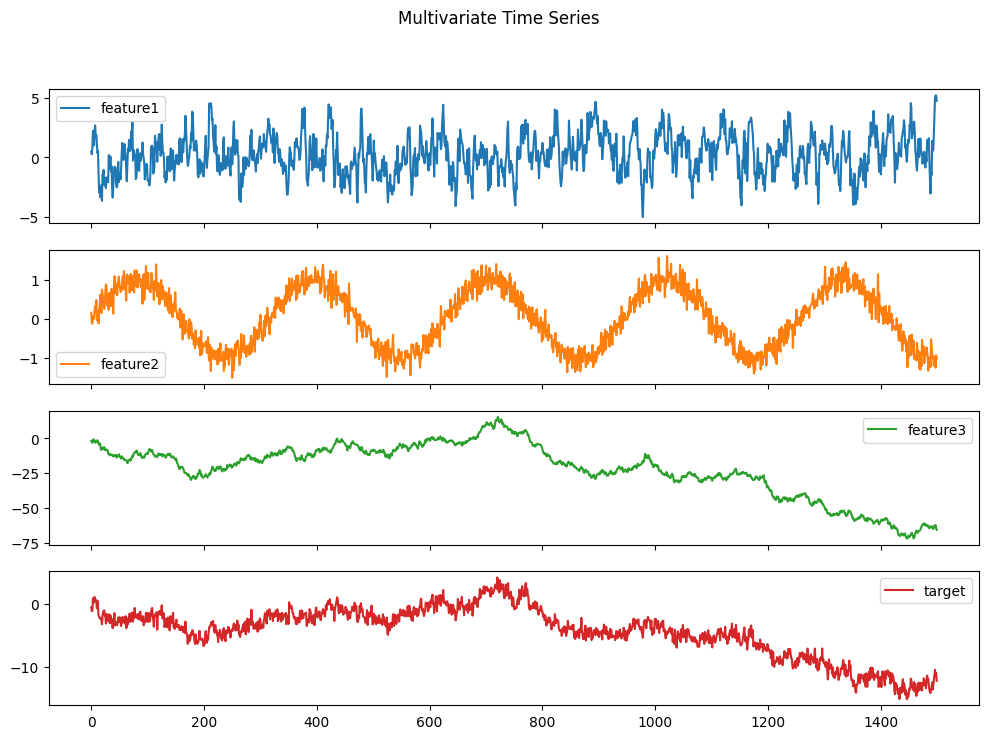

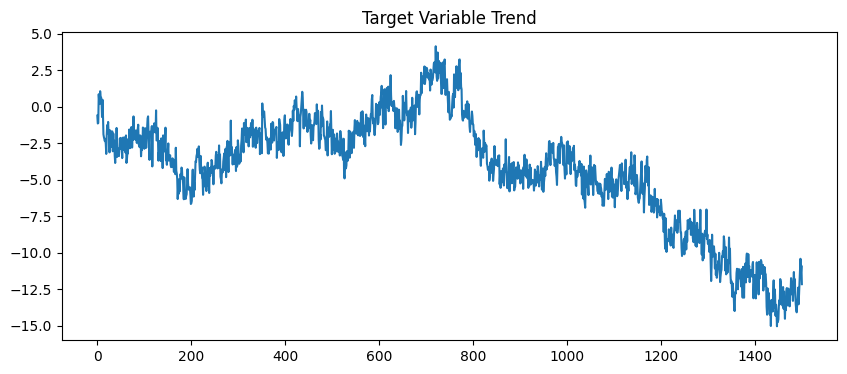

C:\Users\Admin\AppData\Local\Programs\Python\Python313\Lib\site-packages\keras\src\layers\rnn\rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/25
33/33 ━━━━━━━━━━━━━━━━━━━━ 12s 64ms/step - loss: 0.1493 - val_loss: 0.2850
Epoch 2/25
33/33 ━━━━━━━━━━━━━━━━━━━━ 1s 28ms/step - loss: 0.0427 - val_loss: 0.2261
Epoch 3/25
33/33 ━━━━━━━━━━━━━━━━━━━━ 1s 31ms/step - loss: 0.0383 - val_loss: 0.1849
Epoch 4/25
33/33 ━━━━━━━━━━━━━━━━━━━━ 1s 30ms/step - loss: 0.0367 - val_loss: 0.1697
Epoch 5/25
33/33 ━━━━━━━━━━━━━━━━━━━━ 1s 24ms/step - loss: 0.0359 - val_loss: 0.1615
Epoch 6/25
33/33 ━━━━━━━━━━━━━━━━━━━━ 2s 37ms/step - loss: 0.0353 - val_loss: 0.1567
Epoch 7/25
33/33 ━━━━━━━━━━━━━━━━━━━━ 1s 31ms/step - loss: 0.0347 - val_loss: 0.1553
Epoch 8/25
33/33 ━━━━━━━━━━━━━━━━━━━━ 1s 29ms/step - loss: 0.0344 - val_loss: 0.1551
Epoch 9/25
33/33 ━━━━━━━━━━━━━━━━━━━━ 1s 28ms/step - loss: 0.0340 - val_loss: 0.1560
Epoch 10/25
33/33 ━━━━━━━━━━━━━━━━━━━━ 1s 27ms/step - loss: 0.0338 - val_loss: 0.1565
Epoch 11/25
33/33 ━━━━━━━━━━━━━━━━━━━━ 2s 44ms/step - loss: 0.0334 - val_loss: 0.1572
Epoch 12/25
33/33 ━━━━━━━━━━━━━━━━━━━━ 3s 39ms/step - loss: 0.

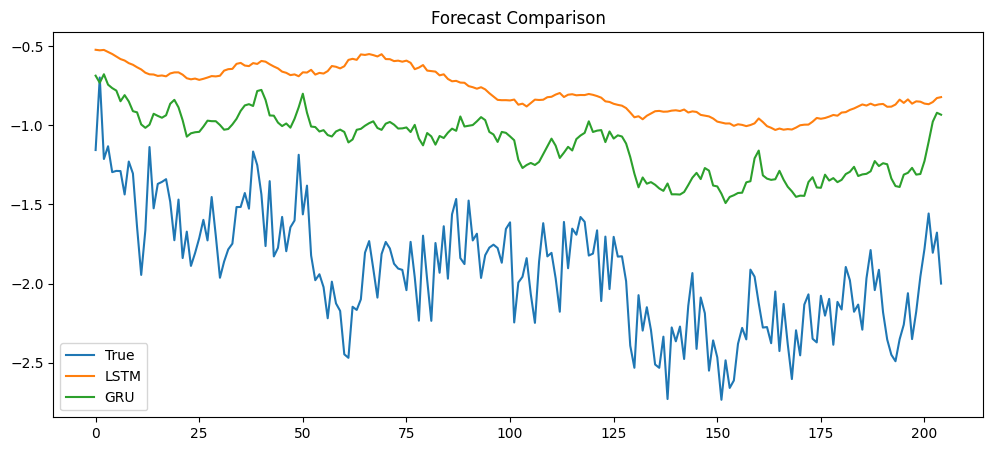

In [3]:
# -------------------------------
# IMPORTS
# -------------------------------
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error
from statsmodels.tsa.arima_process import ArmaProcess
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, GRU, Dense
from tensorflow.keras.callbacks import EarlyStopping

# -------------------------------
# 1. GENERATE MULTIVARIATE SYNTHETIC TIME SERIES DATA
# -------------------------------
np.random.seed(42)

# Create AR process for trend-like structure
ar = np.array([1, -0.8])
ma = np.array([1])
arma = ArmaProcess(ar, ma)

n = 1500
feature1 = arma.generate_sample(nsample=n)
feature2 = np.sin(np.linspace(0, 30, n)) + np.random.normal(0, 0.2, n)
feature3 = np.random.normal(0, 1, n).cumsum()  # random walk

# Target = weighted combination + noise
target = 0.4 * feature1 + 0.3 * feature2 + 0.2 * feature3 + np.random.normal(0, 0.5, n)

df = pd.DataFrame({
    "feature1": feature1,
    "feature2": feature2,
    "feature3": feature3,
    "target": target
})

print(df.head())

# -------------------------------
# 2. EDA
# -------------------------------
df.plot(subplots=True, figsize=(12, 8), title="Multivariate Time Series")
plt.show()

plt.figure(figsize=(10, 4))
plt.plot(df["target"])
plt.title("Target Variable Trend")
plt.show()

# -------------------------------
# 3. PREPROCESSING
# -------------------------------
scaler = StandardScaler()
scaled_data = scaler.fit_transform(df)

scaled_df = pd.DataFrame(scaled_data, columns=df.columns)

# -------------------------------
# 4. TRAIN-TEST SPLIT
# -------------------------------
train_size = int(len(scaled_df) * 0.7)
val_size = int(len(scaled_df) * 0.15)

train = scaled_df[:train_size]
val = scaled_df[train_size:train_size + val_size]
test = scaled_df[train_size + val_size:]

# -------------------------------
# 5. WINDOW GENERATOR
# -------------------------------
def create_window(data, window=20):
    X, y = [], []
    for i in range(len(data) - window):
        X.append(data.iloc[i:i + window].values)
        y.append(data.iloc[i + window]["target"])
    return np.array(X), np.array(y)

window = 20
X_train, y_train = create_window(train, window)
X_val, y_val = create_window(val, window)
X_test, y_test = create_window(test, window)

# -------------------------------
# 6. LSTM MODEL
# -------------------------------
def build_lstm():
    model = Sequential([
        LSTM(64, return_sequences=False, input_shape=(window, scaled_df.shape[1])),
        Dense(32, activation="relu"),
        Dense(1)
    ])
    model.compile(loss="mse", optimizer="adam")
    return model

lstm = build_lstm()
es = EarlyStopping(patience=5, restore_best_weights=True)

lstm.fit(X_train, y_train,
         validation_data=(X_val, y_val),
         epochs=25, batch_size=32,
         callbacks=[es])

y_pred_lstm = lstm.predict(X_test)

# -------------------------------
# 7. GRU MODEL
# -------------------------------
def build_gru():
    model = Sequential([
        GRU(64, return_sequences=False, input_shape=(window, scaled_df.shape[1])),
        Dense(32, activation="relu"),
        Dense(1)
    ])
    model.compile(loss="mse", optimizer="adam")
    return model

gru = build_gru()

gru.fit(X_train, y_train,
        validation_data=(X_val, y_val),
        epochs=25, batch_size=32,
        callbacks=[es])

y_pred_gru = gru.predict(X_test)

# -------------------------------
# 8. PERFORMANCE METRICS
# -------------------------------
def evaluate(true, pred):
    rmse = np.sqrt(mean_squared_error(true, pred))
    mae = mean_absolute_error(true, pred)
    return rmse, mae

rmse_lstm, mae_lstm = evaluate(y_test, y_pred_lstm)
rmse_gru, mae_gru = evaluate(y_test, y_pred_gru)

results = pd.DataFrame({
    "Model": ["LSTM", "GRU"],
    "RMSE": [rmse_lstm, rmse_gru],
    "MAE": [mae_lstm, mae_gru]
})

print(results)

# -------------------------------
# 9. PLOTS
# -------------------------------
plt.figure(figsize=(12, 5))
plt.plot(y_test, label="True")
plt.plot(y_pred_lstm, label="LSTM")
plt.plot(y_pred_gru, label="GRU")
plt.legend()
plt.title("Forecast Comparison")
plt.show()
